In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score, recall_score, precision_score, make_scorer, confusion_matrix
from sklearn.inspection import permutation_importance

In [2]:
def build_clustering_dataset_optimized(
    data,
    lepol_time,
    kiln_time,
    refroidisseur_time,
    type="mean",
    tol=0.01,
    include_std=False
):
    data = data.copy()
    data.index = pd.to_datetime(data.index)
    data = data[~data.index.duplicated(keep='first')]

    total_window = lepol_time + kiln_time + refroidisseur_time

    lepol_features = [
        'Température sur chambre chaude ',
        'Temperature Air Secondaire',
        'Oxygene Sortie Four',
        'NOx Sortie Four',
        'SO2 Sortie Four',
        'CO Sortie Four'
    ]

    kiln_features = [
        'Intensite Moteur Four',
        'Temperature Zone'
    ]

    input_features = [
        'Debit moyen entree farine Four  (CF)',
        'Debit Injection SQ7',
        'Debit moyen SOLVEN in Kiln'
    ]

    min_time = data.index.min()
    max_time = data.index.max()
    full_range = pd.date_range(start=min_time, end=max_time, freq='min')
    data_reindexed = data.reindex(full_range)

    valid_mask = data_reindexed.index.isin(data.index)

    quality_arr = data_reindexed['Mesure traitee CaOl Alcatron'].values
    input_arrays = {col: data_reindexed[col].values for col in input_features}
    lepol_arrays = {col: data_reindexed[col].values for col in lepol_features}
    kiln_arrays = {col: data_reindexed[col].values for col in kiln_features}

    max_start_idx = len(data_reindexed) - total_window - 1
    if max_start_idx < 0:
        return pd.DataFrame()

    valid_starts = []
    for i in range(max_start_idx + 1):
        lepol_end = i + lepol_time
        kiln_end = lepol_end + kiln_time
        refroid_idx = i + total_window
        if (refroid_idx < len(valid_mask) and
            valid_mask[i:lepol_end + 1].all() and
            valid_mask[lepol_end:kiln_end + 1].all() and
            valid_mask[refroid_idx]):
            valid_starts.append(i)

    if not valid_starts:
        return pd.DataFrame()

    valid_starts = np.array(valid_starts)
    n_windows = len(valid_starts)
    end_indices = valid_starts + total_window
    end_times = full_range[end_indices]

    print(f"Building {n_windows} valid windows...")

    result_dict = {
        'Time': end_times,
        'Mesure traitee CaOl Alcatron': quality_arr[end_indices]
    }

    # input features at start
    for col in input_features:
        result_dict[col] = input_arrays[col][valid_starts]

    # lepol / kiln features
    if type in ["mean", "mean_std"]:
        for col in lepol_features:
            arr = lepol_arrays[col]
            means = np.empty(n_windows, dtype=float)
            stds = np.empty(n_windows, dtype=float) if include_std else None
            for j, start_idx in enumerate(valid_starts):
                segment = arr[start_idx:start_idx + lepol_time + 1]
                means[j] = np.nanmean(segment)
                if include_std:
                    stds[j] = np.nanstd(segment)
            result_dict[f"{col}_lepol_mean"] = means
            if include_std:
                result_dict[f"{col}_lepol_std"] = stds

        for col in kiln_features:
            arr = kiln_arrays[col]
            means = np.empty(n_windows, dtype=float)
            stds = np.empty(n_windows, dtype=float) if include_std else None
            for j, start_idx in enumerate(valid_starts):
                kstart = start_idx + lepol_time
                segment = arr[kstart:kstart + kiln_time + 1]
                means[j] = np.nanmean(segment)
                if include_std:
                    stds[j] = np.nanstd(segment)
            result_dict[f"{col}_kiln_mean"] = means
            if include_std:
                result_dict[f"{col}_kiln_std"] = stds

    elif type == "segment":
        # Lepol features
        for col in lepol_features:
            arr = lepol_arrays[col]
            for i in range(lepol_time + 1):
                result_dict[f"{col}_lepol_t{i}"] = [arr[start_idx + i] for start_idx in valid_starts]
    
        # Kiln features
        for col in kiln_features:
            arr = kiln_arrays[col]
            for i in range(kiln_time + 1):
                result_dict[f"{col}_kiln_t{i}"] = [arr[start_idx + lepol_time + i] for start_idx in valid_starts]

    clustering_data = pd.DataFrame(result_dict)
    clustering_data.set_index("Time", inplace=True)

    labels_arr = np.full(n_windows, -1, dtype=int)
    curr_idx = end_indices
    prev_idx = curr_idx - 1
    valid_prev = (prev_idx >= 0) & valid_mask[prev_idx]

    if valid_prev.any():
        curr_vals = quality_arr[curr_idx[valid_prev]]
        prev_vals = quality_arr[prev_idx[valid_prev]]
        ok_vals = (~np.isnan(curr_vals)) & (~np.isnan(prev_vals)) & (curr_vals != 0) & (prev_vals != 0)
        label_mask = ok_vals & (np.abs(curr_vals - prev_vals) > tol)
        labels = np.where(curr_vals[label_mask] <= 3.5, 1, 0)
        positions = np.flatnonzero(valid_prev)
        label_positions = positions[label_mask]
        labels_arr[label_positions] = labels

    clustering_data['Labels'] = labels_arr
    return clustering_data


In [3]:
csv_path = "/Users/foucauld/Desktop/stage_centre_Borelli/Clean_code/Clustering/clean_raw_data.csv"

data = pd.read_csv(csv_path, sep=',')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)
print(len(data))
# Keep the first row for each timestamp
data = data[~data.index.duplicated(keep='first')]
print(len(data))

96358
94919


In [4]:
clustering_data_optimal_time_mean = build_clustering_dataset_optimized(data, lepol_time=20, kiln_time=30, refroidisseur_time=40, type="mean",tol=0.01, include_std=False)

Building 94649 valid windows...


In [5]:
class_0 = clustering_data_optimal_time_mean[clustering_data_optimal_time_mean['Labels'] == 0]
class_1 = clustering_data_optimal_time_mean[clustering_data_optimal_time_mean['Labels'] == 1]

labellised_data = pd.concat([class_0, class_1])

X_mean = labellised_data.drop(columns=['Labels'])
y_mean = labellised_data['Labels']

X_train_normal = X_mean[y_mean == 1]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_mean)

one_class_svm = OneClassSVM(kernel="rbf", gamma='scale', nu=0.005)
one_class_svm.fit(X_train_scaled)

y_pred = one_class_svm.predict(X_test_scaled)

y_pred_binary = np.where(y_pred == 1, 1, 0)

f1_score = f1_score(y_mean, y_pred_binary)
recall = recall_score(y_mean, y_pred_binary)
precision = precision_score(y_mean, y_pred_binary)
print("F1 Score:", round(f1_score, 3))
print("Recall Score:", round(recall, 3))
print("Precision Score:", round(precision, 3))

F1 Score: 0.976
Recall Score: 0.986
Precision Score: 0.965


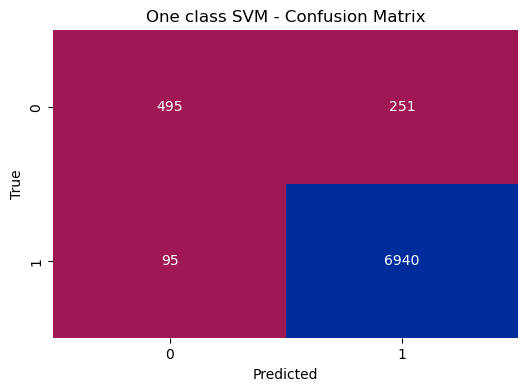

In [7]:
colors = ['#9f1853', '#002d9c']  
cm = confusion_matrix(y_mean, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.matplotlib.colors.ListedColormap(colors), cbar=False)
plt.title('One class SVM - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()